# Two-sample-test

This notebook contains six two-sample tests implemented on GMM.

Ref: https://torch-two-sample.readthedocs.io/en/latest/#djolonga17graphtests


## Installation
Install the package with: 

<font face=Time New Roman>python setup.py install</font>

If you got error message "unable to execute '/usr/local/bin/gcc': No such file or directory error", you can try: 

<font face=Time New Roman>MACOSX_DEPLOYMENT_TARGET=10.9 CC=clang CXX=clang++ python setup.py install</font>

Ref: https://github.com/pytorch/audio/issues/57


## Import packages

In [1]:
import torch
import torch.distributions as D
import numpy as np
import torch_two_sample as ts
import torch.nn as nn
from torch.autograd import Variable
from itertools import permutations
from matplotlib import pyplot as plt


dtype = torch.float
device = torch.device("cpu")

In [2]:
print(torch.__version__)

1.6.0



## Generate GMM samples


In [3]:
# generated 3 different samples from 3 dimensional GMM
# - all have same components distribution (pi)
# - first two come from the same distribution, 
# - while the last one from a distribution with a different mean & 

# seed
torch.manual_seed(100)

n_components = 2
n_attributes = 3

# components distribution
mix = D.categorical.Categorical(torch.tensor([0.2, 0.8]))

# - random means
mu12 = torch.randn(n_components, n_attributes)
mu3  = torch.randn(n_components, n_attributes)
print("True mean of sample 1 & 2:\n", mu12)
print("True mean of sample  3:\n", mu3)

# - random covariance matrix
def randn_sigma(n_components, n_attributes):
    """
    generate random covariance matrix 
    args:
            n_components:   number of mixed components
            n_attributes:   number of mixed attributes
    output: 
            covariance matrix 
    """
    x = torch.rand(n_components, n_attributes, n_attributes)
    x_t = torch.transpose(x, 1, 2)
    sigma = torch.empty(n_components, n_attributes, n_attributes)
    for i in range(0, n_components):
        sigma[i] = torch.mm(x[i], x_t[i])
    return(sigma)
sigma12 = randn_sigma(n_components, n_attributes)
sigma3  = randn_sigma(n_components, n_attributes)
print("True covariance matrix of sample 1 & 2:\n", sigma12)
print("True covariance matrix of sample 3:\n", sigma3)

# component distributions
comp12 = D.multivariate_normal.MultivariateNormal(mu12, sigma12) 
comp3 = D.multivariate_normal.MultivariateNormal(mu3, sigma3) 

# mixture distributions
gmm12 = D.mixture_same_family.MixtureSameFamily(mix, comp12)
gmm3 = D.mixture_same_family.MixtureSameFamily(mix, comp3)

# generate sample from GMM model & require dradient
dat1 = gmm12.sample(torch.Size([100]))
dat2 = gmm12.sample(torch.Size([100]))
dat3 = gmm3.sample(torch.Size([100]))

True mean of sample 1 & 2:
 tensor([[ 0.3607, -0.2859, -0.3938],
        [ 0.2429, -1.3833, -2.3134]])
True mean of sample  3:
 tensor([[-0.3172, -0.8660,  1.7482],
        [-0.2759, -0.9755,  0.4790]])
True covariance matrix of sample 1 & 2:
 tensor([[[1.6498, 0.9685, 1.0574],
         [0.9685, 0.7886, 0.8720],
         [1.0574, 0.8720, 0.9651]],

        [[0.2284, 0.4517, 0.3936],
         [0.4517, 1.4348, 1.2194],
         [0.3936, 1.2194, 1.0603]]])
True covariance matrix of sample 3:
 tensor([[[0.6384, 0.5191, 0.9332],
         [0.5191, 0.5413, 0.7309],
         [0.9332, 0.7309, 1.3758]],

        [[0.8527, 0.9381, 0.9646],
         [0.9381, 1.1672, 1.3059],
         [0.9646, 1.3059, 1.6537]]])


## Differentiable Friedman-Rafsky test



### Statistical testing

In [4]:
# create the object that implements the test
n = 100
fr_test = ts.SmoothFRStatistic(n, n, cuda=False, compute_t_stat=True)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_sfr, matrix_12_sfr = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    alphas=[4.], ret_matrix=True)
t_val_13_sfr, matrix_13_sfr = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    alphas=[4.], ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_sfr.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_sfr.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_sfr, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_sfr, n_permutations=1000))


/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/inference_trees.py:95: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:32.)
  return torch.masked_select(matrix, triu_mask)
/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/inference_trees.py:79: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:18.)
  return matrix.masked_scatter(triu_mask, triu)
/Users/zhilingtan/opt/

1 vs 2 0.7245067739387798
1 vs 3 0.0
1 vs 2 0.718999981880188
1 vs 3 0.0


In [5]:
# print t-statistics
print(t_val_12_sfr.data.item())
print(t_val_13_sfr.data.item())

-0.5962826013565063
32.557437896728516



### Implicit model learning

In [6]:
batch_size = 100
epoch = 100
avg_losses = []

# generator
generator = nn.Sequential(
    nn.Linear(n_attributes, batch_size),  # Receive a 3 dimensional noise vector as input.
    nn.ReLU(),  # Then, a single hidden layer of 3 units with ReLU.
    nn.Linear(batch_size, n_attributes))  # output shape: [100, 3]

# optimizer
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

# new sample for traning
train = gmm12.sample(torch.Size([1000]))

# loss function
loss_fn = ts.SmoothFRStatistic(
    batch_size, batch_size, cuda=False, compute_t_stat=True)

for epoch in range(1, epoch):
    trainloader=torch.utils.data.DataLoader(train, batch_size=batch_size)
    
    losses = []
    
    noise_tensor_sfr = torch.randn(batch_size, n_attributes)
    noise_sfr = Variable(noise_tensor_sfr)
    
    for batch in trainloader:
        noise_tensor_sfr.normal_()
        optimizer.zero_grad()
        loss = loss_fn(Variable(batch), generator(noise_sfr), alphas=[0.1])
        loss.backward()
        losses.append(loss.data.item())
        optimizer.step()
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)
    
    # every 10 epoch print one message
    if epoch % 10 == 0:
        p = 1 - norm.cdf(loss.data.item())
        print('epoch {0:>2d}, avg loss {1}, p.val {2}'.format(epoch, avg_loss, p))

/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/inference_trees.py:95: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:32.)
  return torch.masked_select(matrix, triu_mask)
/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/inference_trees.py:79: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:18.)
  return matrix.masked_scatter(triu_mask, triu)
/Users/zhilingtan/opt/

epoch 10, avg loss 1.3048433363437653, p.val 0.09200485319568585
epoch 20, avg loss 0.5313569370191544, p.val 0.4979719986792501
epoch 30, avg loss -0.010889067500829696, p.val 0.4622570288146054
epoch 40, avg loss 0.11309703439474106, p.val 0.6917675969960282
epoch 50, avg loss -0.2039967080578208, p.val 0.47589316882472277
epoch 60, avg loss 0.18020620793104172, p.val 0.7741492203626759
epoch 70, avg loss -0.054097936302423474, p.val 0.5254214347534047
epoch 80, avg loss -0.1847742938436568, p.val 0.5861612550120954
epoch 90, avg loss -0.053741597570478916, p.val 0.4660057335134248




### Model evaluation

In [7]:
print(torch.mean(generator(noise_sfr), dim = 0))

print(mu12[0] * 0.2 + mu12[1] * 0.8)
print(torch.mean(train, dim = 0))

tensor([ 0.2775, -1.1539, -1.9190], grad_fn=<MeanBackward1>)
tensor([ 0.2665, -1.1638, -1.9295])
tensor([ 0.2785, -1.1340, -1.9277])


In [8]:
print(np.cov(generator(noise_sfr).detach().numpy(), rowvar=False))
print(np.cov(train, rowvar=False))

[[0.29466527 0.63280032 0.60741466]
 [0.63280032 1.98724836 1.91351678]
 [0.60741466 1.91351678 1.97864187]]
[[0.4761175  0.53412013 0.52369846]
 [0.53412013 1.42925484 1.42451161]
 [0.52369846 1.42451161 1.57511109]]




### Visualization

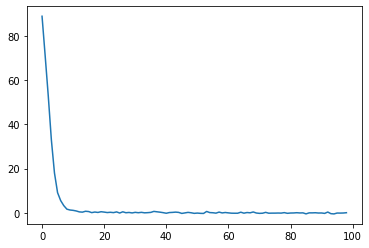

In [9]:
plt.plot(avg_losses)
plt.show()

## Differentiable k-nearest neighbours (kNN) test

### Statistical testing

In [10]:
# create the object that implements the test
n = 100
fr_test = ts.SmoothKNNStatistic(n, n, False, 1, compute_t_stat=True)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_sknn, matrix_12_sknn = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    alphas=[4.], ret_matrix=True)
t_val_13_sknn, matrix_13_sknn = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    alphas=[4.], ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_sknn.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_sknn.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_sknn, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_sknn, n_permutations=1000))

1 vs 2 0.7643196348958232
1 vs 3 0.0


/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/statistics_diff.py:242: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:32.)
  diffs = torch.masked_select(diffs, indices).view(n, n - 1)
/Users/zhilingtan/opt/anaconda3/lib/python3.7/site-packages/torch_two_sample-0.1-py3.7-macosx-10.9-x86_64.egg/torch_two_sample/statistics_diff.py:269: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/aten/src/ATen/native/LegacyDefinitions.cpp:18.)
  margs.masked_scatter_(indices_cpu, margs_.view(-1))


1 vs 2 0.7549999952316284
1 vs 3 0.0


In [11]:
# print t-statistics
print(t_val_12_sknn.data.item())
print(t_val_13_sknn.data.item())

-0.7202668190002441
28.510269165039062


### Implicit model learning

In [12]:
batch_size = 100
epoch = 100
avg_losses = []

# generator
generator = nn.Sequential(
    nn.Linear(n_attributes, batch_size),  # Receive a 3 dimensional noise vector as input.
    nn.ReLU(),  # Then, a single hidden layer of 3 units with ReLU.
    nn.Linear(batch_size, n_attributes))  # output shape: [100, 3]

# optimizer
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

# new sample for traning
train = gmm12.sample(torch.Size([1000]))
#train.requires_grad_(True)

# loss function
loss_fn = ts.SmoothKNNStatistic(
    batch_size, batch_size, False, 2, compute_t_stat=True)

for epoch in range(1, epoch):
    trainloader=torch.utils.data.DataLoader(train, batch_size=batch_size)
    
    noise_tensor_sknn = torch.randn(batch_size, n_attributes)
    
    losses = []
    
    noise_sknn = Variable(noise_tensor_sknn)
    
    for batch in trainloader:
        noise_tensor_sknn.normal_()
        optimizer.zero_grad()
        loss = loss_fn(Variable(batch), generator(noise_sknn), alphas=[0.1])
        loss.backward()
        losses.append(loss.data.item())
        optimizer.step()
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)
    
    # every 10 epoch print one message
    if epoch % 10 == 0:
        p = 1 - norm.cdf(loss.data.item())
        print('epoch {0:>2d}, avg loss {1}, p.val {2}'.format(epoch, avg_loss, p))

epoch 10, avg loss 3.0293137222528457, p.val 0.3376702517696012
epoch 20, avg loss 0.868544127047062, p.val 0.1906602040318245
epoch 30, avg loss 0.17830850295722483, p.val 0.5941089835034372
epoch 40, avg loss 0.0614202119410038, p.val 0.6414376662844881
epoch 50, avg loss 0.45118196699768304, p.val 0.6644028699620553
epoch 60, avg loss -0.1021827831864357, p.val 0.7037062390667843
epoch 70, avg loss 0.3638848029077053, p.val 0.27579721256784584
epoch 80, avg loss 0.22219126373529435, p.val 0.6616745058501193
epoch 90, avg loss -0.37322318758815526, p.val 0.7121830513265247


### Model evaluation

In [13]:
print(torch.mean(generator(noise_sknn), dim = 0))

print(mu12[0] * 0.2 + mu12[1] * 0.8)
print(torch.mean(train, dim = 0))

tensor([ 0.3247, -1.1331, -1.9118], grad_fn=<MeanBackward1>)
tensor([ 0.2665, -1.1638, -1.9295])
tensor([ 0.2472, -1.1894, -1.9700])


In [14]:
print(np.cov(generator(noise_sknn).detach().numpy(), rowvar=False))
print(np.cov(train, rowvar=False))

[[0.34375988 0.59260076 0.60371385]
 [0.59260076 2.01905514 2.05011283]
 [0.60371385 2.05011283 2.26998122]]
[[0.51554768 0.60652672 0.58887163]
 [0.60652672 1.58919164 1.55386643]
 [0.58887163 1.55386643 1.66873617]]


### Visualization


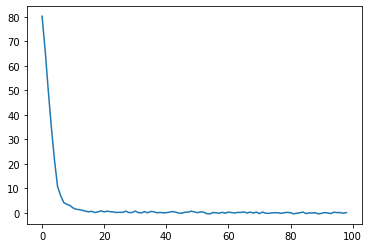

In [15]:
plt.plot(avg_losses)
plt.show()

## Maximum mean discrepancy (MMD) test

### Statistical testing

In [16]:
# create the object that implements the test
n = 100
fr_test = ts.MMDStatistic(n, n)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_mmd, matrix_12_mmd = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    alphas=[4.], ret_matrix=True)
t_val_13_mmd, matrix_13_mmd = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    alphas=[4.], ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_mmd.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_mmd.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_mmd, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_mmd, n_permutations=1000))

1 vs 2 0.5002036239108035
1 vs 3 0.4569894437474311
1 vs 2 0.4790000021457672
1 vs 3 0.0


In [17]:
# print t-statistics
print(t_val_12_mmd.data.item())
print(t_val_13_mmd.data.item())

-0.0005104094743728638
0.10802118480205536


### implicit model learning

In [18]:
batch_size = 100
epoch = 100
avg_losses = []

# generator
generator = nn.Sequential(
    nn.Linear(n_attributes, batch_size),  # Receive a 3 dimensional noise vector as input.
    nn.ReLU(),  # Then, a single hidden layer of 3 units with ReLU.
    nn.Linear(batch_size, n_attributes))  # output shape: [100, 3]

# optimizer
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

# new sample for traning
train = gmm12.sample(torch.Size([1000]))

# loss function
loss_fn = ts.MMDStatistic(
    batch_size, batch_size)

for epoch in range(1, epoch):
    trainloader=torch.utils.data.DataLoader(train, batch_size=batch_size)
    
    losses = []
    
    noise_tensor_mmd = torch.randn(batch_size, n_attributes)
    noise_mmd = Variable(noise_tensor_mmd)
    
    for batch in trainloader:
        noise_tensor_mmd.normal_()
        optimizer.zero_grad()
        loss = loss_fn(Variable(batch), generator(noise_mmd), alphas=[0.1])
        loss.backward()
        losses.append(loss.data.item())
        optimizer.step()
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)
    
    # every 10 epoch print one message
    if epoch % 10 == 0:
        p = 1 - norm.cdf(loss.data.item())
        print('epoch {0:>2d}, avg loss {1}, p.val {2}'.format(epoch, avg_loss, p))

epoch 10, avg loss 0.03061848282814026, p.val 0.4850890928062973
epoch 20, avg loss 0.00395880937576294, p.val 0.498306549366724
epoch 30, avg loss 0.00392683744430542, p.val 0.5003207285939699
epoch 40, avg loss 0.0056379735469818115, p.val 0.49941359090601534
epoch 50, avg loss 0.006846904754638672, p.val 0.4994376550397348
epoch 60, avg loss 0.0045315146446228026, p.val 0.4995995648578485
epoch 70, avg loss 0.007047545909881592, p.val 0.5011624256242201
epoch 80, avg loss 0.002347004413604736, p.val 0.5006068826290003
epoch 90, avg loss 0.0018665313720703125, p.val 0.5000955432693559


### Model evaluation

In [19]:
print(torch.mean(generator(noise_mmd), dim = 0))

print(mu12[0] * 0.2 + mu12[1] * 0.8)
print(torch.mean(train, dim = 0))

tensor([ 0.2795, -1.2803, -2.1185], grad_fn=<MeanBackward1>)
tensor([ 0.2665, -1.1638, -1.9295])
tensor([ 0.2720, -1.2108, -1.9879])


In [20]:
print(np.cov(generator(noise_mmd).detach().numpy(), rowvar=False))
print(np.cov(train, rowvar=False))

[[0.46535764 0.52047855 0.47175308]
 [0.52047855 1.56024825 1.58648164]
 [0.47175308 1.58648164 1.69919741]]
[[0.46298937 0.56328553 0.54197319]
 [0.56328553 1.55949202 1.5287289 ]
 [0.54197319 1.5287289  1.64299178]]


### Visualization

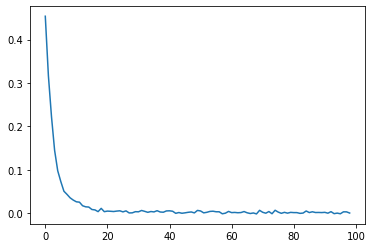

In [21]:
plt.plot(avg_losses)
plt.show()

## Energy test

### Statistical testing 

In [22]:
# create the object that implements the test
n = 100
fr_test = ts.EnergyStatistic(n, n)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_eng, matrix_12_eng = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    ret_matrix=True)
t_val_13_eng, matrix_13_eng = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_eng.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_eng.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_eng, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_eng, n_permutations=1000))

1 vs 2 0.48528643971020524
1 vs 3 0.005568980696791681
1 vs 2 0.46000000834465027
1 vs 3 0.0


In [23]:
# print t-statistics
print(t_val_12_eng.data.item())
print(t_val_13_eng.data.item())

0.03688979148864746
2.5383403301239014


### Implicit model learning

In [24]:
batch_size = 100
epoch = 100
avg_losses = []

# generator
generator = nn.Sequential(
    nn.Linear(n_attributes, batch_size),  # Receive a 3 dimensional noise vector as input.
    nn.ReLU(),  # Then, a single hidden layer of 3 units with ReLU.
    nn.Linear(batch_size, n_attributes))  # output shape: [100, 3]

# optimizer
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

# new sample for traning
train = gmm12.sample(torch.Size([1000]))

# loss function
loss_fn = ts.EnergyStatistic(
    batch_size, batch_size)

for epoch in range(1, epoch):
    trainloader=torch.utils.data.DataLoader(train, batch_size=batch_size)
    
    losses = []
    
    noise_tensor_eng = torch.randn(batch_size, n_attributes)
    noise_eng = Variable(noise_tensor_eng)
    
    for batch in trainloader:
        noise_tensor_eng.normal_()
        optimizer.zero_grad()
        loss = loss_fn(Variable(batch), generator(noise_eng))
        loss.backward()
        losses.append(loss.data.item())
        optimizer.step()
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)
    
    # every 10 epoch print one message
    if epoch % 10 == 0:
        p = 1 - norm.cdf(loss.data.item())
        print('epoch {0:>2d}, avg loss {1}, p.val {2}'.format(epoch, avg_loss, p))

epoch 10, avg loss 0.21830077171325685, p.val 0.39595001317492795
epoch 20, avg loss 0.11663748025894165, p.val 0.4450191145626512
epoch 30, avg loss 0.08126863241195678, p.val 0.4471144552412095
epoch 40, avg loss 0.05509335994720459, p.val 0.4787028825938483
epoch 50, avg loss 0.051135790348052976, p.val 0.46971999147867527
epoch 60, avg loss 0.04354811906814575, p.val 0.4805519797163368
epoch 70, avg loss 0.06851503849029542, p.val 0.4274538811360231
epoch 80, avg loss 0.05517507791519165, p.val 0.4785842539093068
epoch 90, avg loss 0.060315489768981934, p.val 0.4815655250627975


### Model evaluation

In [25]:
print(torch.mean(generator(noise_eng), dim = 0))

print(mu12[0] * 0.2 + mu12[1] * 0.8)
print(torch.mean(train, dim = 0))

tensor([ 0.2554, -1.3349, -2.1676], grad_fn=<MeanBackward1>)
tensor([ 0.2665, -1.1638, -1.9295])
tensor([ 0.2534, -1.1784, -1.9442])


In [26]:
print(np.cov(generator(noise_mmd).detach().numpy(), rowvar=False))
print(np.cov(train, rowvar=False))

[[0.34980881 0.56488867 0.53152254]
 [0.56488867 1.70570681 1.61282033]
 [0.53152254 1.61282033 1.68006294]]
[[0.51204391 0.57597898 0.55267943]
 [0.57597898 1.51402221 1.48563699]
 [0.55267943 1.48563699 1.61363026]]


### Visualization

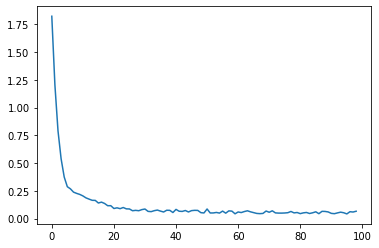

In [27]:
plt.plot(avg_losses)
plt.show()

## Classical Friedman-Rafsky test

### Statistical testing

In [28]:
# create the object that implements the test
n = 100
fr_test = ts.EnergyStatistic(n, n)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_frs, matrix_12_frs = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    ret_matrix=True)
t_val_13_frs, matrix_13_frs = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_frs.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_frs.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_frs, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_frs, n_permutations=1000))

1 vs 2 0.48528643971020524
1 vs 3 0.005568980696791681
1 vs 2 0.46399998664855957
1 vs 3 0.0


In [29]:
# print t-statistics
print(t_val_12_frs.data.item())
print(t_val_13_frs.data.item())

0.03688979148864746
2.5383403301239014


##  Classical k-nearest neighbours (kNN) test

### Statistical testing

In [30]:
# create the object that implements the test
n = 100
fr_test = ts.KNNStatistic(n, n, 1)

# compute_t_stat=True, 
# - which means that fr_test.__call__ will compute a t-statistic, 
#   so that we can obtain an approximate p-value from it using the 
#   CDF of a standard normal. 
#   We have implemented t-statistics only for the smooth graph tests.


# compute the t-statistics
t_val_12_knn, matrix_12_knn = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat2),
    ret_matrix=True)
t_val_13_knn, matrix_13_knn = fr_test(
    torch.autograd.Variable(dat1), 
    torch.autograd.Variable(dat3),
    ret_matrix=True)


# compute approximate p-values from the normal’s CDF 
from scipy.stats import norm   # To evaluate the CDF of a normal.
print('1 vs 2', 1 - norm.cdf(t_val_12_knn.data.item()))
print('1 vs 3', 1 - norm.cdf(t_val_13_knn.data.item()))


# compute the p-value by sampling from the permutation null
print('1 vs 2', fr_test.pval(matrix_12_knn, n_permutations=1000))
print('1 vs 3', fr_test.pval(matrix_13_knn, n_permutations=1000))

1 vs 2 0.0
1 vs 3 0.0
1 vs 2 0.9589999914169312
1 vs 3 0.0


In [31]:
# print t-statistics
print(t_val_12_knn.data.item())
print(t_val_13_knn.data.item())

84.0
195.0
